In [ ]:
import numpy as np
from pymatching import Matching
import matplotlib.pyplot as plt
from scipy import sparse, linalg
import CompassCodes as cc
import stim 
import pandas as pd


In [ ]:
pip show stim

In [ ]:
!python --version

In [ ]:
surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=1,
    distance=3,
    # after_clifford_depolarization=0.001,
    # after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.05)
    # before_round_data_depolarization=0.001)

In [ ]:
print(repr(surface_code_circuit))

In [ ]:
sc_no_err = stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    R 1 3 5 8 10 12 15 17 19 2 9 11 13 14 16 18 25
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    TICK
    MR 2 9 11 13 14 16 18 25
    DETECTOR(0, 4, 0) rec[-4]
    DETECTOR(2, 2, 0) rec[-7]
    DETECTOR(4, 4, 0) rec[-2]
    DETECTOR(6, 2, 0) rec[-5]
    M 1 3 5 8 10 12 15 17 19
    DETECTOR(0, 4, 1) rec[-3] rec[-6] rec[-13]
    DETECTOR(2, 2, 1) rec[-5] rec[-6] rec[-8] rec[-9] rec[-16]
    DETECTOR(4, 4, 1) rec[-1] rec[-2] rec[-4] rec[-5] rec[-11]
    DETECTOR(6, 2, 1) rec[-4] rec[-7] rec[-14]
    OBSERVABLE_INCLUDE(0) rec[-7] rec[-8] rec[-9]
''')

In [ ]:
sc_err =stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    R 1 3 5 8 10 12 15 17 19 2 9 11 13 14 16 18 25
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    TICK
    X_ERROR(0.05) 2 9 11 13 14 16 18 25
    MR 2 9 11 13 14 16 18 25
    DETECTOR(0, 4, 0) rec[-4]
    DETECTOR(2, 2, 0) rec[-7]
    DETECTOR(4, 4, 0) rec[-2]
    DETECTOR(6, 2, 0) rec[-5]
    X_ERROR(0.05) 1 3 5 8 10 12 15 17 19
    M 1 3 5 8 10 12 15 17 19
    DETECTOR(0, 4, 1) rec[-3] rec[-6] rec[-13]
    DETECTOR(2, 2, 1) rec[-5] rec[-6] rec[-8] rec[-9] rec[-16]
    DETECTOR(4, 4, 1) rec[-1] rec[-2] rec[-4] rec[-5] rec[-11]
    DETECTOR(6, 2, 1) rec[-4] rec[-7] rec[-14]
    OBSERVABLE_INCLUDE(0) rec[-7] rec[-8] rec[-9]
''')

In [ ]:
matching_from_c = Matching.from_stim_circuit(sc_err)
matching_from_c.draw()
print(matching_from_c)

In [ ]:
d = 5
l = 2

compass_code = cc.CompassCode(d=d, l=l)
H_x, H_z = compass_code.H['X'], compass_code.H['Z']
log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']

In [ ]:
def convert_sparse_to_d(sparse_mat):
    rows, cols, values = sparse.find(sparse_mat)
    d = {}

    for i in range(len(rows)):
        plaq = rows[i]
        qubit = cols[i]

        if plaq not in d:
            d[plaq] = [cols[i]]
        else:
            d[plaq] += [cols[i]]
    sorted_d = dict(sorted(zip(d.keys(),d.values())))
    return sorted_d

d_z = convert_sparse_to_d(H_z)
print(d_z)

d_x = convert_sparse_to_d(H_x)
print(d_x)

In [ ]:
def qubit_to_plaq_d(H):
    """ Makes a dictionary that records which plaquettes belong to qubits
    """
    rows, cols, values = sparse.find(H)
    d = {}
    for i in range(len(cols)):
        q = cols[i]
        plaq = rows[i]

        if q not in d:
            d[q] = [plaq]
        else:
            d[q] += [plaq]
    return d
d = qubit_to_plaq_d(H_x)
print(d)

In [ ]:
def check_order_d(H, type):
    """ Change this for longer codes
        Right now (from STIM ex): 
         HX: 0 - TR, 1 - TL, 2 - BR, 3 - BL
         HZ: 0 - TR, 1 - BR, 2 - TL, 3 - BL
    """
    plaq_d = convert_sparse_to_d(H)
    order_d = {0:[], 1:[], 2:[], 3:[]}
    d = int(np.sqrt(H.shape[1]))

    for plaq in plaq_d:
        q_list = plaq_d[plaq] # the list of qubits in the plaquette
        if type == "X":
            if len(q_list) == 2 and max(q_list) <= H.shape[1]//2: # if the two qubit stabilizer is on the top bndry
                order_d[2] += [(q_list[1], plaq)]
                order_d[3] += [(q_list[0], plaq)]
            elif len(q_list) == 2 and max(q_list) >= H.shape[1]//2: # if the two qubit stabilizer is on bottom 
                order_d[0] += [(q_list[1], plaq)]
                order_d[1] += [(q_list[0], plaq)]
            else: # length 4 plaquette
                order_d[0] += [(q_list[1], plaq)]
                order_d[1] += [(q_list[0], plaq)]
                order_d[2] += [(q_list[3], plaq)]
                order_d[3] += [(q_list[2], plaq)]
        if type == "Z": 
            if len(plaq_d[plaq]) == 2 and (q_list[0]-q_list[1])%d == 0 and q_list[0]%d == 0: # if the two qubit stabilizer is on the left bndry
                order_d[0] += [(q_list[0], plaq)]
                order_d[1] += [(q_list[1], plaq)]
            elif len(plaq_d[plaq]) == 2 and (q_list[0]-q_list[1])%d == 0 and q_list[0]%d != 0: # if the two qubit stabilizer is on right bndry 
                order_d[2] += [(q_list[0], plaq)]
                order_d[3] += [(q_list[1], plaq)]
            else: # length 4 plaquette
                order_d[0] += [(q_list[1], plaq)]
                order_d[1] += [(q_list[3], plaq)]
                order_d[2] += [(q_list[0], plaq)]
                order_d[3] += [(q_list[2], plaq)]
                
    return order_d

order_d_x = check_order_d(H_x, "X")
print(order_d_x)
order_d_z = check_order_d(H_z, "Z")
print(order_d_z)


In [ ]:
def make_circuit_from_parity(H_x, H_z, p_err, type):
    """ 
    create a surface code memory experiment circuit from a parity check matrix
    """
    
    # make the circuit
    circuit = stim.Circuit()

    # get the qubit ordering
    plaq_d_x = convert_sparse_to_d(H_x)
    plaq_d_z = convert_sparse_to_d(H_z)
    
    order_d_x = check_order_d(H_x, "X")
    order_d_z = check_order_d(H_z, "Z")
    
    qubit_d_x = qubit_to_plaq_d(H_x)
    qubit_d_z = qubit_to_plaq_d(H_z)
    
    # general parameters
    num_ancillas = len(plaq_d_x) + len(plaq_d_z)
    num_qubits = len(qubit_d_x)
    d = int(np.sqrt(num_qubits))
    data_q_x_list = [num_ancillas + q for q in list(qubit_d_x.keys())]
    data_q_z_list = [num_ancillas + q for q in list(qubit_d_z.keys())]
    data_q_list = data_q_x_list

    # convention - X plaqs first, then Z plaqs starting with 0
    full_plaq_L = range(len(plaq_d_x) + len(plaq_d_z))
    
    # reset the ancillas
    circuit.append("R", full_plaq_L)
    circuit.append("H", plaq_d_x)

    # reset the qubits
    for q in range(len(qubit_d_x)):
        if type == "X":
            circuit.append("RX", q + num_ancillas)
        if type == "Z":
            circuit.append("R", q + num_ancillas)
 
    
    for order in order_d_x: # go thru the qubits in order of gates
        q_x_list = order_d_x[order] # (qubit, ancilla)
        q_z_list = order_d_z[order]
        
        for q,p in q_x_list:
            circuit.append("CX", [p, q + num_ancillas])
        
        for q,p in q_z_list:
            circuit.append("CX", [q + num_ancillas, p + len(plaq_d_x)])
        
        circuit.append("TICK")
    
    circuit.append("H", plaq_d_x)
    circuit.append("X_ERROR", full_plaq_L, p_err)
    circuit.append("MR", full_plaq_L)

    # for X mem measure X plaqs
    if type == "X":
        for i in range(len(plaq_d_x)):
            circuit.append("DETECTOR", stim.target_rec(-num_ancillas + i))
    
        circuit.append("Z_ERROR", data_q_list, p_err)
        circuit.append("MX", data_q_list)

        # time to reconstruct each plaquette
        for i in plaq_d_x: 
            
            q_x_list = plaq_d_x[i] # get the qubits in the plaq
            anc = i 
            detector_list =  [-num_qubits + q for q in q_x_list] + [-num_ancillas + anc - num_qubits]
            
            circuit.append("DETECTOR", [stim.target_rec(d) for d in detector_list])
    
        # construct the logical observable to include - pick the top line of qubits since this is an X meas
        circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(- num_qubits + d*q) for q in range(d)], 0) # parity of the whole line needs to be the same
    
    # Z mem measure Z plaqs
    if type == "Z":
        for i in range(len(plaq_d_z)):
            circuit.append("DETECTOR", stim.target_rec(-num_ancillas + i + len(plaq_d_x)))
    
        circuit.append("X_ERROR", data_q_list, p_err)
        circuit.append("M", data_q_list)

        # time to reconstruct each plaquette
        for i in plaq_d_z: 
            
            q_z_list = plaq_d_z[i] # get the qubits in the plaq
            anc = i 
            detector_list =  [-num_qubits + q for q in q_z_list] + [-num_ancillas +len(plaq_d_x)+ anc - num_qubits]
            
            circuit.append("DETECTOR", [stim.target_rec(d) for d in detector_list])
    
        # construct the logical observable to include - pick the top line of qubits since this is an X meas
        circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(- num_qubits + q) for q in range(d)], 0)
    return circuit
            
circuit = make_circuit_from_parity(H_x, H_z, 0.05, "Z")            
print(repr(circuit))   

In [ ]:
d = 5
l = 2
num_shots = 10000

compass_code = cc.CompassCode(d=d, l=l)
H_x, H_z = compass_code.H['X'], compass_code.H['Z']
log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']

my_c = make_circuit_from_parity(H_x,H_z,0.05, "Z")
print(repr(my_c))

In [ ]:
matching_p = Matching.from_check_matrix(H_z)
matching_p.draw()

In [ ]:
matching_p.edges()

In [ ]:

matching_my_c = Matching.from_stim_circuit(my_c)
matching_my_c.draw()

In [ ]:
matching_my_c.edges()

In [ ]:
matching_sc = Matching.from_stim_circuit(sc_err)
matching_sc.draw()

In [ ]:
matching_sc.edges()

In [ ]:
dem = my_c.detector_error_model()
print(repr(dem))

In [ ]:
dem.diagram("matchgraph-svg")

In [ ]:
dem_stim = sc_err.detector_error_model()
print(repr(dem_stim))

In [ ]:
dem_stim.diagram("matchgraph-svg")

In [ ]:
def get_num_log_errors(circuit, matching, num_shots):
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)
    predictions = matching.decode_batch(detection_events)
    
    
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

# num_errors = get_num_log_errors(my_c, matching_my_c, num_shots)
# num_errors_stim = get_num_log_errors(sc_err, matching_from_c, num_shots)
# print("for my circuit", num_errors)
# print("for stim built in circuit", num_errors_stim)

In [ ]:
def get_log_error_p(p_list, H_x,H_z, type, d, num_shots):
    log_error_L = []
    for p in p_list:
        circuit = make_elongated_circuit_from_parity(H_x, H_z, d, p, type)
        matching = Matching.from_stim_circuit(circuit)
        
        log_errors = get_num_log_errors(circuit, matching, num_shots)
        log_error_L += [log_errors/num_shots]
    return log_error_L
    

In [ ]:
p_list = np.linspace(0,0.5, 50)
d_dict = {5:[], 7:[], 9:[], 11:[]}
num_shots = 100000
l = 2
type_d = {0:"X", 1:"Z"}
type=type_d[0]


for d in list(d_dict.keys()):
    compass_code = cc.CompassCode(d=d, l=l)
    H_x, H_z = compass_code.H['X'], compass_code.H['Z']
    log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']

    
    d_dict[d] = get_log_error_p(p_list, H_x,H_z, num_shots)

In [ ]:
for d in d_dict:
    plt.plot(p_list, d_dict[d], label=f"d={d}")
plt.xlabel("p")
plt.ylabel(f"{[v for k, v in type_d.items() if v != type][0]} Logical Errors ")
plt.legend()
plt.savefig("l2_eta05_zmem.png", dpi=300)
plt.show()

In [ ]:
log_error_L = []
for p in p_list:
    sc_circuit = surface_code_circuit = stim.Circuit.generated("surface_code:rotated_memory_x",rounds=1, distance=3, before_measure_flip_probability=p)
    log_errors = get_num_log_errors(sc_circuit, matching_from_c, num_shots)
    log_error_L += [log_errors/num_shots]

plt.plot(p_list, log_error_L)
plt.show()


Now try to implement the elongated version

In [ ]:
d = 3
l = 2

compass_code = cc.CompassCode(d=d, l=l)
H_x, H_z = compass_code.H['X'], compass_code.H['Z']
log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']

print("Hx",H_x)
# print("Hz",H_z)

In [ ]:
row_ind = 2
start = H_x.indptr[row_ind]
end = H_x.indptr[row_ind+1]

column_indices = H_x.indices[start:end]
print(sorted(column_indices))

In [ ]:
def check_order_d_elongated(H, type):
    """ Change this for longer codes
        Right now (from STIM ex): 
         HX: 0 - TR, 1 - TL, 2 - BR, 3 - BL
         HZ: 0 - TR, 1 - BR, 2 - TL, 3 - BL
    """
    # create the order dictionary to store the qubit ordering for each plaquette
    order_d = {}
    for row in range(H.shape[0]):
        order_d[row] = []

    # get the qubit ordering for each plaquette
    for row in range(H.shape[0]):
        start = H.indptr[row]
        end = H.indptr[row+1]
        qubits = sorted(H.indices[start:end]) # the qubits in the plaquette
        
        if type == "Z":
            for i in range(len(qubits)//2):
                match_qubit_ind = np.where(qubits == (qubits[i] + d))[0][0]
                order_d[row] += [(qubits[i], row)]
                order_d[row] += [(qubits[match_qubit_ind], row)]

        if type == "X":
            for qubit in qubits:
                order_d[row] += [(qubit, row)]
    return order_d

In [ ]:

order_d_x = check_order_d_elongated(H_x, "X")
print(order_d_x)
print(H_x.shape)

In [ ]:
def make_elongated_circuit_from_parity(H_x, H_z, d, p_err, eta, type):
    """ 
    create a surface code memory experiment circuit from a parity check matrix

    I think the error type I wanna use is pauli_channel_1(px, py, pz)
    """
    px = 0.5*p_err/(1+eta)
    pz = p_err*(eta/(1+eta))

    # make the circuit
    circuit = stim.Circuit()

    # get the qubit ordering
    plaq_d_x = convert_sparse_to_d(H_x)
    plaq_d_z = convert_sparse_to_d(H_z)
    
    # get the qubit ordered properly for each plaquette
    order_d_x = check_order_d_elongated(H_x, "X")
    order_d_z = check_order_d_elongated(H_z, "Z")
    
    # get the plaquettes that belong to each qubit
    qubit_d_x = qubit_to_plaq_d(H_x)
    qubit_d_z = qubit_to_plaq_d(H_z)
    
    # general parameters
    num_ancillas = len(plaq_d_x) + len(plaq_d_z) # total number of plaquettes to initialize
    num_qubits_x = len(qubit_d_x)
    num_qubits_z = len(qubit_d_z)
    
    data_q_x_list = [num_ancillas + q for q in list(qubit_d_x.keys())] # all the x data qubits
    data_q_z_list = [num_ancillas + q for q in list(qubit_d_z.keys())] # all the z data qubits
    data_q_list = data_q_x_list # change this later when wanna do X and Z seperately


    # convention - X plaqs first, then Z plaqs starting with 0
    full_plaq_L = range(num_ancillas)
    
    # reset the ancillas
    circuit.append("R", full_plaq_L)
    circuit.append("H", plaq_d_x) # only the X plaqs need H

    # reset the qubits
    for q in range(len(qubit_d_x)): # go through all the qubits, might need to change when qubit_d_x doesn't have all the qubits
        if type == "X":
            circuit.append("RX", q + num_ancillas)
        if type == "Z":
            circuit.append("R", q + num_ancillas)
 
    
    for order in order_d_x: # go through the qubits in order of gates
        q_x_list = order_d_x[order] # (qubit, ancilla)
        
        for q,p in q_x_list:
            circuit.append("CX", [p, q + num_ancillas])
        
        circuit.append("TICK")


    for order in order_d_z: # go through the qubits in order of gates
        q_z_list = order_d_z[order]

        for q,p in q_z_list:
            circuit.append("CX", [q + num_ancillas, p + len(plaq_d_x)])
    
    circuit.append("H", plaq_d_x)
    # circuit.append("PAULI_CHANNEL_1", full_plaq_L, [px,px,pz]) # measurement errors???
    circuit.append("MR", full_plaq_L)

    # for X mem measure X plaqs
    if type == "X":
        for i in range(len(plaq_d_x)):
            circuit.append("DETECTOR", stim.target_rec(-num_ancillas + i))

        circuit.append("PAULI_CHANNEL_1", data_q_x_list, [px,px,pz])
        # circuit.append("Z_ERROR", data_q_x_list, p_err) # errors on the data qubits
        circuit.append("MX", data_q_x_list)

        # reconstruct each plaquette
        for i in plaq_d_x: 
            q_x_list = plaq_d_x[i] # get the qubits in the plaq
            anc = i 
            detector_list =  [-num_qubits_x + q for q in q_x_list] + [-num_ancillas + anc - num_qubits_x]
            
            circuit.append("DETECTOR", [stim.target_rec(d) for d in detector_list])
    
        # construct the logical observable to include - pick the top line of qubits since this is an X meas
        circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(- num_qubits_x + d*q) for q in range(d)], 0) # parity of the whole line needs to be the same
    
    # Z mem measure Z plaqs
    if type == "Z":
        for i in range(len(plaq_d_z)):
            circuit.append("DETECTOR", stim.target_rec(-num_ancillas + i + len(plaq_d_x)))

        circuit.append("PAULI_CHANNEL_1", data_q_z_list, [px,px,pz])
        # circuit.append("X_ERROR", data_q_list, p_err) # errors on the data qubits
        circuit.append("M", data_q_list)

        # time to reconstruct each plaquette
        for i in plaq_d_z: 
            
            q_z_list = plaq_d_z[i] # get the qubits in the plaq
            anc = i 
            detector_list =  [-num_qubits_z + q for q in q_z_list] + [-num_ancillas +len(plaq_d_x)+ anc - num_qubits_z]
            circuit.append("DETECTOR", [stim.target_rec(d) for d in detector_list])
    
        # construct the logical observable to include - pick the top line of qubits since this is an X meas
        circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(-num_qubits_z + q) for q in range(d)], 0)
    return circuit

In [ ]:
def get_log_error_p(p_list, H_x,H_z, type, eta, d, num_shots):
    log_error_L = []
    for p in p_list:
        circuit = make_elongated_circuit_from_parity(H_x, H_z, d, p, eta, type)
        matching = Matching.from_stim_circuit(circuit)
        
        log_errors = get_num_log_errors(circuit, matching, num_shots)
        log_error_L += [log_errors/num_shots]
    return log_error_L
    

In [ ]:
d = 5
l = 3

compass_code = cc.CompassCode(d=d, l=l)
H_x, H_z = compass_code.H['X'], compass_code.H['Z']
log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']
my_c = make_elongated_circuit_from_parity(H_x,H_z, d, 0.05, 0.5, "Z")
print(H_x)
print(repr(my_c))

In [ ]:
matching_p = Matching.from_check_matrix(H_z)
matching_p.draw()


In [ ]:
matching_my_c = Matching.from_stim_circuit(my_c)
matching_my_c.draw()
# my_c.diagram('detslice-with-ops-svg', tick=range(0, 5), filter_coords=['D13', ])

In [ ]:
p_list = np.linspace(0,0.5, 50)
d_dict = {5:[], 7:[], 9:[], 11:[]}
num_shots = 100000
l = 3
type_d = {0:"X", 1:"Z"}
type=type_d[0]
eta = 1.67

prob_scale = {'X': 0.5/(1+eta), 'Z': (1+2*eta)/(2*(1+eta)), 'CORR_Z': 1, 'TOTAL':1}


for d in list(d_dict.keys()):
    compass_code = cc.CompassCode(d=d, l=l)
    H_x, H_z = compass_code.H['X'], compass_code.H['Z']
    log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']

    d_dict[d] = get_log_error_p(p_list, H_x,H_z, type,eta, d, num_shots)

In [ ]:
p_list = np.linspace(0,0.5, 50)
d_dict = {5:[], 7:[], 9:[], 11:[]}
num_shots = 100000
l = 3
type_d = {0:"X", 1:"Z"}
type=type_d[0]
eta = 1.67

prob_scale = {'X': 0.5/(1+eta), 'Z': (1+2*eta)/(2*(1+eta)), 'CORR_Z': 1, 'TOTAL':1}

def get_log_error_p(p_list, H_x,H_z, type, eta, d, num_shots):
    log_error_L = []
    for p in p_list:
        circuit = make_elongated_circuit_from_parity(H_x, H_z, d, p, eta, type)
        matching = Matching.from_check_matrix(circuit)
        
        log_errors = get_num_log_errors(circuit, matching, num_shots)
        log_error_L += [log_errors/num_shots]
    return log_error_L
    


for d in list(d_dict.keys()):
    compass_code = cc.CompassCode(d=d, l=l)
    H_x, H_z = compass_code.H['X'], compass_code.H['Z']
    log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']

    d_dict[d] = get_log_error_p(p_list, H_x,H_z, type,eta, d, num_shots)

In [ ]:
for d in d_dict:
    plt.plot(p_list*prob_scale[type], d_dict[d], label=f"d={d}")
plt.xlabel("p")
plt.ylabel(f"{[v for k, v in type_d.items() if v != type][0]} Logical Errors ")
plt.legend()
# plt.savefig("l3_eta1.67_zmem.png", dpi=300)
plt.show()

In [ ]:
for d in d_dict:
    plt.plot(p_list, d_dict[d], label=f"d={d}")
plt.xlabel("p")
plt.ylabel(f"{[v for k, v in type_d.items() if v != type][0]} Logical Errors ")
plt.legend()
plt.savefig("l3_eta05_xmem.png", dpi=300)
plt.show()

Trying to make circuit for clifford deformed codes

In [ ]:
from CompassCodes import CD_data_func, Clifford_vectorTrans
import CompassCodes as cc

In [ ]:
compass_code = cc.CompassCode(d=5, l=3, type='XZZXonSq')
q_bits = compass_code.qbit_dict
print(q_bits)
type_dict = {'type': 'XZZX'}
CD_data = CD_data_func(q_bits.values(), type='XZZXonSq', ell=3)

print(CD_data)

In [ ]:
circuit = stim.Circuit("""
QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(1, 3) 8
QUBIT_COORDS(2, 2) 9
QUBIT_COORDS(3, 3) 10
QUBIT_COORDS(4, 2) 11
QUBIT_COORDS(5, 3) 12
QUBIT_COORDS(6, 2) 13
QUBIT_COORDS(0, 4) 14
QUBIT_COORDS(1, 5) 15
QUBIT_COORDS(2, 4) 16
QUBIT_COORDS(3, 5) 17
QUBIT_COORDS(4, 4) 18
QUBIT_COORDS(5, 5) 19
QUBIT_COORDS(4, 6) 25
RX 1 3 5 8 10 12 15 17 19
R 2 9 11 13 14 16 18 25
TICK
H 2 11 16 25
DEPOLARIZE1(0.001) 2 11 16 25
TICK
CX 2 3 16 17 11 12 15 14 10 9 19 18
DEPOLARIZE2(0.001) 2 3 16 17 11 12 15 14 10 9 19 18
TICK
CX 2 1 16 15 11 10 8 14 3 9 12 18
DEPOLARIZE2(0.001) 2 1 16 15 11 10 8 14 3 9 12 18
TICK
CX 16 10 11 5 25 19 8 9 17 18 12 13
DEPOLARIZE2(0.001) 16 10 11 5 25 19 8 9 17 18 12 13
TICK
CX 16 8 11 3 25 17 1 9 10 18 5 13
DEPOLARIZE2(0.001) 16 8 11 3 25 17 1 9 10 18 5 13
TICK
H 2 11 16 25
DEPOLARIZE1(0.001) 2 11 16 25
TICK
MR 2 9 11 13 14 16 18 25
DETECTOR(2, 0, 0) rec[-8]
DETECTOR(2, 4, 0) rec[-3]
DETECTOR(4, 2, 0) rec[-6]
DETECTOR(4, 6, 0) rec[-1]
REPEAT 2 {
    TICK
    H 2 11 16 25
    DEPOLARIZE1(0.001) 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    DEPOLARIZE2(0.001) 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    DEPOLARIZE2(0.001) 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    DEPOLARIZE2(0.001) 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    DEPOLARIZE2(0.001) 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    DEPOLARIZE1(0.001) 2 11 16 25
    TICK
    MR 2 9 11 13 14 16 18 25
    SHIFT_COORDS(0, 0, 1)
    DETECTOR(2, 0, 0) rec[-8] rec[-16]
    DETECTOR(2, 2, 0) rec[-7] rec[-15]
    DETECTOR(4, 2, 0) rec[-6] rec[-14]
    DETECTOR(6, 2, 0) rec[-5] rec[-13]
    DETECTOR(0, 4, 0) rec[-4] rec[-12]
    DETECTOR(2, 4, 0) rec[-3] rec[-11]
    DETECTOR(4, 4, 0) rec[-2] rec[-10]
    DETECTOR(4, 6, 0) rec[-1] rec[-9]
}
MX 1 3 5 8 10 12 15 17 19
DETECTOR(2, 0, 1) rec[-8] rec[-9] rec[-17]
DETECTOR(2, 4, 1) rec[-2] rec[-3] rec[-5] rec[-6] rec[-12]
DETECTOR(4, 2, 1) rec[-4] rec[-5] rec[-7] rec[-8] rec[-15]
DETECTOR(4, 6, 1) rec[-1] rec[-2] rec[-10]
OBSERVABLE_INCLUDE(0) rec[-3] rec[-6] rec[-9]
""")

In [ ]:
d = 3
circuit = stim.Circuit.generated(
                    "surface_code:rotated_memory_z",
                    rounds=3,
                    distance=3,
                    after_clifford_depolarization=0,
                    after_reset_flip_probability=0,
                    before_measure_flip_probability=0.1,
                    before_round_data_depolarization=0,
                )
circuit.diagram("timeline-svg")

In [ ]:
from clifford_deformed_cc_circuit import CDCompassCodeCircuit
circuit_obj = CDCompassCodeCircuit(d=3, l=2, p_params=[0,0,0.1], eta=0.5, type='Z')
circuit = circuit_obj.make_elongated_circuit_from_parity()
# circuit.diagram('timeslice-svg', tick=range(6,12))
circuit.diagrame

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from pymatching import Matching

p_list = np.linspace(0.01, 0.1, 10)
d_list = [3,5,7]
num_shots = 100000

log_error_L = []

for d in d_list:
    errors = []
    for p in p_list:
        
        circuit = stim.Circuit.generated(
                    "surface_code:rotated_memory_x",
                    rounds=d,
                    distance=d,
                    after_clifford_depolarization=0,
                    after_reset_flip_probability=0,
                    before_measure_flip_probability=p,
                    before_round_data_depolarization=p,
                )
        dem = circuit.detector_error_model() # what does the decompose do?
        matchgraph = Matching.from_detector_error_model(dem)
        sampler = circuit.compile_detector_sampler()
        syndrome, observable_flips = sampler.sample(num_shots, separate_observables=True)
        predictions = matchgraph.decode_batch(syndrome)
        num_errors = np.sum(np.any(np.array(observable_flips) != np.array(predictions), axis=1))
        errors.append(num_errors/num_shots)

    log_error_L.append(np.array(errors))

# circuit.diagram("timeline-svg")

In [ ]:
circuit = stim.Circuit.generated(
                    "surface_code:rotated_memory_x",
                    rounds=3,
                    distance=3,
                    after_clifford_depolarization=0,
                    after_reset_flip_probability=0,
                    before_measure_flip_probability=0.1,
                    before_round_data_depolarization=0,
                )
circuit.diagram("timeline-svg")
print(repr(circuit))

In [ ]:
%matplotlib inline

plt.figure()
for d, logical_errors in zip(d_list, log_error_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(p_list, logical_errors, yerr=std_err, label="d={}".format(d))
plt.yscale("log")
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from pymatching import Matching
from clifford_deformed_cc_circuit import CDCompassCodeCircuit

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from pymatching import Matching
from clifford_deformed_cc_circuit import CDCompassCodeCircuit

p_list = np.linspace(0.01, 0.1, 10)
d_list = [3,5,7]
num_shots = 100000

log_error_L = []

for d in d_list:
    errors = []
    for p in p_list:
        circuit_obj = CDCompassCodeCircuit(d=d, l=2, p_params=[0,p,p], eta=0.5, type='Z')
        circuit = circuit_obj.make_elongated_circuit_from_parity()
        dem = circuit.detector_error_model() # what does the decompose do?
        matchgraph = Matching.from_detector_error_model(dem)
        sampler = circuit.compile_detector_sampler()
        syndrome, observable_flips = sampler.sample(num_shots, separate_observables=True)
        predictions = matchgraph.decode_batch(syndrome)
        num_errors = np.sum(np.any(np.array(observable_flips) != np.array(predictions), axis=1))
        errors.append(num_errors/num_shots)


    log_error_L.append(np.array(errors))

In [30]:
circuit_obj = CDCompassCodeCircuit(d=3, l=2, p_params=[0,0,0.1], eta=0.5, type='X')
circuit = circuit_obj.make_elongated_circuit_from_parity()
dem = circuit.detector_error_model()
# circuit.diagram('detslice-with-ops-svg', tick=range(0, 5), filter_coords=['D0', 'D4', ])
# circuit.diagram('timeline-svg')
# dem
circuit
# matching_from_c = Matching.from_detector_error_model(dem)
# matching_from_c.draw()


stim.Circuit('''
    R 0 1 2 3 4 5 6 7
    RX 8 9 10 11 12 13 14 15 16
    DEPOLARIZE1(0.1) 8 9 10 11 12 13 14 15 16
    TICK
    H 0 1 2 3
    CX 0 8 0 9 0 11 0 12 1 14 1 15 2 9 2 10 3 12 3 13 3 15 3 16
    H 0 1 2 3
    TICK
    CX 8 4 11 4 9 5 12 5 10 5 13 5 11 6 14 6 12 6 15 6 13 7 16 7
    TICK
    X_ERROR(0.1) 0 1 2 3 4 5 6 7
    MR 0 1 2 3 4 5 6 7
    DETECTOR rec[-8]
    DETECTOR rec[-7]
    DETECTOR rec[-6]
    DETECTOR rec[-5]
    TICK
    REPEAT 2 {
        DEPOLARIZE1(0.1) 8 9 10 11 12 13 14 15 16
        H 0 1 2 3
        CX 0 8 0 9 0 11 0 12 1 14 1 15 2 9 2 10 3 12 3 13 3 15 3 16
        H 0 1 2 3
        TICK
        CX 8 4 11 4 9 5 12 5 10 5 13 5 11 6 14 6 12 6 15 6 13 7 16 7
        TICK
        X_ERROR(0.1) 0 1 2 3 4 5 6 7
        MR 0 1 2 3 4 5 6 7
        DETECTOR rec[-8] rec[-16]
        DETECTOR rec[-7] rec[-15]
        DETECTOR rec[-6] rec[-14]
        DETECTOR rec[-5] rec[-13]
        DETECTOR rec[-4] rec[-12]
        DETECTOR rec[-3] rec[-11]
        DETECTOR r

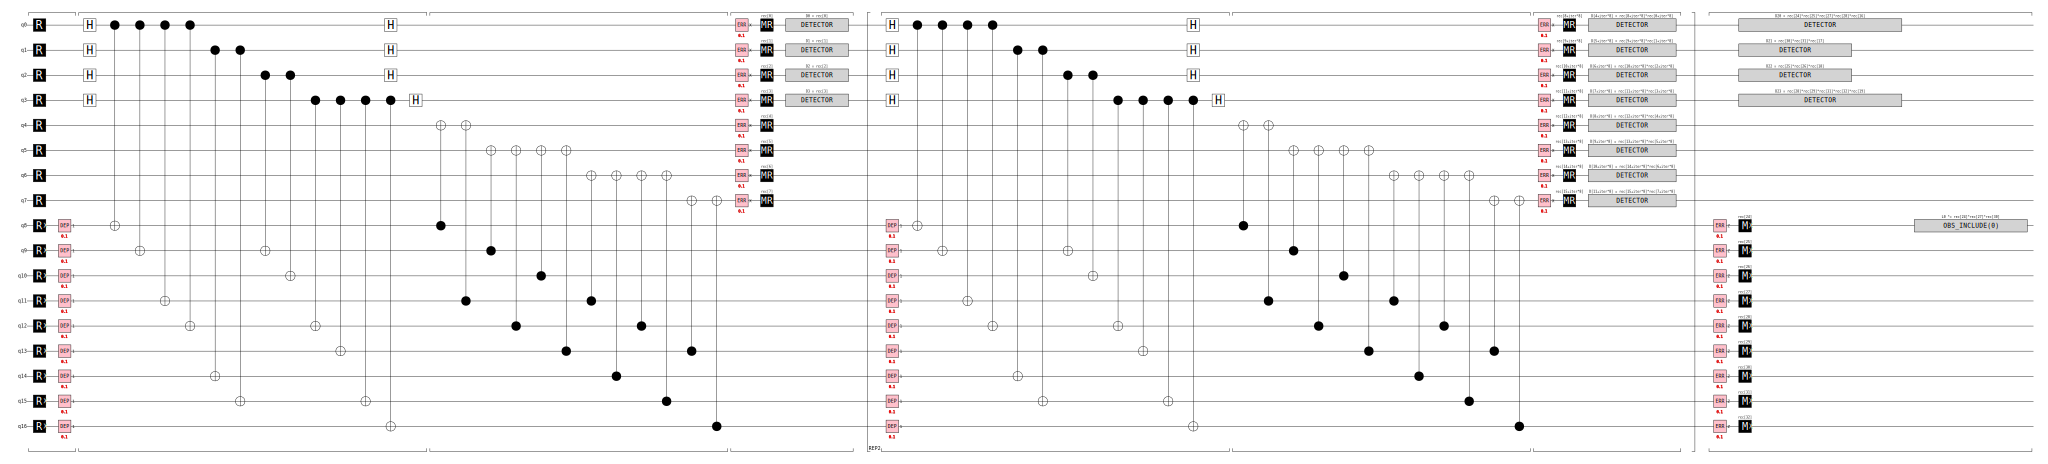

In [31]:
circuit.diagram('timeline-svg')

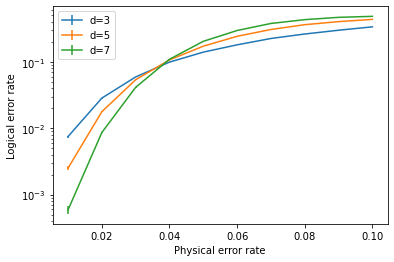

In [32]:
%matplotlib inline

plt.figure()
for d, logical_errors in zip(d_list, log_error_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(p_list, logical_errors, yerr=std_err, label="d={}".format(d))
plt.yscale("log")
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);

Now try to do multiple observables

In [ ]:
test_circuit = stim.Circuit("""
QUBIT_COORDS(0, 0) 0
QUBIT_COORDS(1, 0) 1
QUBIT_COORDS(0, 1) 2
QUBIT_COORDS(1, 1) 3
OBSERVABLE_INCLUDE(0) X0 X1
OBSERVABLE_INCLUDE(1) Z0 Z2
MPP X0*X1*X2*X3 Z0*Z1 Z2*Z3
X_ERROR(0.001) 0 1 2 3
MPP X0*X1*X2*X3 Z0*Z1 Z2*Z3
DETECTOR rec[-1] rec[-4]
DETECTOR rec[-2] rec[-5]
DETECTOR rec[-3] rec[-6]
OBSERVABLE_INCLUDE(0) X0 X1
OBSERVABLE_INCLUDE(1) Z0 Z2
""")
test_circuit.diagram('timeline-svg')
dem = test_circuit.detector_error_model()
dem
matchgraph = Matching.from_detector_error_model(dem)
matchgraph.draw()
# dem.diagram("matchgraph-svg")
# test_circuit.shortest_graphlike_error()

In [ ]:
# dem = test_circuit.detector_error_model(flatten_loops=True)
# print(repr(dem))
# detectors_d = {"X": ["D2"], "Z": ["D0", "D1"]}

def isolate_observable(dem: stim.DetectorErrorModel, detectors_d) -> stim.DetectorErrorModel:
    """Returns a new DEM containing only the detector faults for a specific logical observable."""
    dem_x = stim.DetectorErrorModel()
    dem_z = stim.DetectorErrorModel()
    dets_x = {}
    dets_z = {}
    detector_coords = []

    # Deconstruct the DEM and split into X and Z detector dictionaries. Each instruction is stored in the dictionary with probability as the value.
    # Hyperedges are not allowed
    for inst in dem:
        if inst.type == "error":
            # for each inst check whether its a detector or a logic is_relative_detector_id 
            prob_err = inst.args_copy()[0]
            targets = inst.targets_copy()
            dets_x_list = []
            dets_z_list = []
            for target in targets:
                if target.is_relative_detector_id():
                    det = "D" + str(target.val)
                    if det in detectors_d["X"]:
                        dets_x_list.append(det)
                    elif det in detectors_d["Z"]:
                        dets_z_list.append(det)
                elif target.is_logical_observable_id():
                    observable_id = "L" + str(target.val)
                    if observable_id == "L0":
                        dets_x_list.append(observable_id)
                    elif observable_id == "L1":
                        dets_z_list.append(observable_id)
            if dets_x_list:

                key = tuple(dets_x_list)
                print("X key", key)
                if key not in dets_x:
                    dets_x[key] = prob_err
                else:
                    print("hyperege detected in X DEM, combining probabilities")
                    curr_p = dets_x[key]
                    dets_x[key] = curr_p + prob_err - 2 * curr_p * prob_err  # combine probabilities if multiple error mechanisms detected
            if dets_z_list:
                key = tuple(dets_z_list)
                print("Z key",key)
                if key not in dets_z:
                    dets_z[key] = prob_err
                else:
                    print("hyperege detected in Z DEM, combining probabilities")
                    curr_p = dets_z[key]
                    dets_z[key] = curr_p + prob_err - 2 * curr_p * prob_err
        else:
            detector_coords.append(inst) # not sure if I need this to be seperate for X and Z qubits, but I will just keep it and add it to both DEMs
    
    # Construct the new DEMs for X and Z observables
    for key in dets_x.keys():
        prob = dets_x[key]
        targets = [stim.target_relative_detector_id(int(det[1:])) if det[0] == "D" else stim.target_logical_observable_id(0) for det in key]
        dem_x.append("error", prob, targets=targets)
    for key in dets_z.keys():
        prob = dets_z[key]
        targets = [stim.target_relative_detector_id(int(det[1:])) if det[0] == "D" else stim.target_logical_observable_id(1) for det in key]
        dem_z.append("error", prob, targets=targets)

    return dem_x, dem_z

# dem_x,dem_z = isolate_observable(dem)
# print(repr(dem_x))
# print(repr(dem_z))
# dem_z
# print(repr(dem))

# matchgraph = Matching.from_stim_circuit(test_circuit)
# print(matchgraph.edges())
# matchgraph.draw()
# matchgraph.edges()


In [ ]:
p_list = np.linspace(0.01, 0.1, 10)
num_shots = 10
errors = []
for p in p_list:
    circuit = test_circuit
    dem = circuit.detector_error_model(decompose_errors=True) # what does the decompose do?
    matchgraph_x = Matching.from_detector_error_model(dem, logical_observable_index=0)
    matchgraph_z = Matching.from_detector_error_model(dem, logical_observable_index=1)

    sampler = circuit.compile_detector_sampler()
    syndrome, observable_flips = sampler.sample(num_shots, separate_observables=True)

    predictions = matchgraph.decode_batch(syndrome)
    num_errors = np.sum(np.any(np.array(observable_flips) != np.array(predictions), axis=1))
    errors.append(num_errors/num_shots)

%matplotlib inline

plt.figure()
# std_err = (errors*(1-errors)/num_shots)**0.5
plt.errorbar(p_list, errors, label="d={}".format(2))
plt.yscale("log")
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from pymatching import Matching
from clifford_deformed_cc_circuit import CDCompassCodeCircuit

circuit_obj = CDCompassCodeCircuit(d=3, l=2, p_params=[0,0.1,0.1], eta=0.5, type='X')
circuit,detectors_d = circuit_obj.make_elongated_MPP_circuit_from_parity()
# stim_circuit = stim.Circuit(circuit)
# print(repr(circuit))
circuit.diagram("timeline-svg")
# dem = circuit.detector_error_model(decompose_errors=True)
# dem

In [ ]:
circuit_obj = CDCompassCodeCircuit(d=5, l=2, p_params=[0,0,0.1], eta=0.5, type='X')
circuit,detectors_d = circuit_obj.make_elongated_MPP_circuit_from_parity()
dem = circuit.detector_error_model(flatten_loops=True)
# matching_from_c = Matching.from_detector_error_model(dem)
# # matching_from_c.draw()
# dem_x, dem_z = circuit_obj.isolate_observables_DEM()
# matching_from_c_x = Matching.from_detector_error_model(dem_x)
# matching_from_c_z = Matching.from_detector_error_model(dem_z)
# print(repr(dem))
# print(repr(dem_x))
# print(repr(dem_z))
# matching_from_c_z.draw()
print(len(circuit.shortest_graphlike_error()))

In [ ]:
def get_syndrome_sep(detectors_d, syndrome):
    # Parse detector indices
    x_ind = [int(s[1:]) for s in detectors_d["X"]]
    z_ind = [int(s[1:]) for s in detectors_d["Z"]]

    # Total number of detectors
    total_len = syndrome.shape[1]

    # Create boolean masks
    x_mask = np.zeros(total_len, dtype=bool)
    z_mask = np.zeros(total_len, dtype=bool)
    x_mask[x_ind] = True
    z_mask[z_ind] = True

    # Expand to 2D masks
    x_mask_2d = np.tile(x_mask, (syndrome.shape[0], 1))
    z_mask_2d = np.tile(z_mask, (syndrome.shape[0], 1))

    # Apply masks: keep values where True, else set to False
    syndrome_x_dets = np.where(x_mask_2d, syndrome, False)
    syndrome_z_dets = np.where(z_mask_2d, syndrome, False)

    return syndrome_x_dets, syndrome_z_dets

# test with 2 qubit code eg 
# detectors_d = {"X": ["D2"], "Z": ["D0", "D1"]}
# syndrome = np.array([[False, True, True], [False, True, True]]) 
# syndrome_x, syndrome_z = get_syndrome_sep(detectors_d, syndrome)
# print(syndrome_x, syndrome_z)


In [ ]:
# get the logicals for the test circuit


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from pymatching import Matching
from clifford_deformed_cc_circuit import CDCompassCodeCircuit

p_list = np.linspace(0.005, 0.15, 10)
d_list = [3,5,7,9]
# d_list = [3]
num_shots = 1000

log_error_L_x = []
log_error_L_z = []

for d in d_list:
    errors_x = []
    errors_z = []
    print(f"d = {d}")
    for p in p_list:
        circuit_obj = CDCompassCodeCircuit(d=d, l=2, p_params=[0,0,p], eta=0.5, type='X')
        mpp_circuit, detectors_d = circuit_obj.make_elongated_MPP_circuit_from_parity()
        print(len(mpp_circuit.shortest_graphlike_error()), "shortest graph error") # finds the shortest graphlike error for the og circuit ... wanna check the individual circuits
        dem = mpp_circuit.detector_error_model()
        # dem_x, dem_z = circuit_obj.isolate_observables_DEM()
        # print(repr(dem))
        # print(len(dem_z.shortest_graphlike_error()))
        # matchgraph_x = Matching.from_detector_error_model(dem_x)
        # matchgraph_z = Matching.from_detector_error_model(dem_z)
        matchgraph = Matching.from_detector_error_model(dem)
        # print(matchgraph_z.edges())
        sampler = mpp_circuit.compile_detector_sampler()
        syndrome, observable_flips = sampler.sample(num_shots, separate_observables=True) # observable flips is the same shape as syndrome i think 
        # print(observable_flips.shape)
        # syndrome_x, syndrome_z = get_syndrome_sep(detectors_d, syndrome) 

        # now filter the syndrome based on the correct detectors
        # print(syndrome.shape)
        # print(observable_flips.shape)
        predictions = matchgraph.decode_batch(syndrome)
        # print(predictions.shape)
        # print(syndrome_x)
        # predictions_x = matchgraph_x.decode_batch(syndrome_x)
        # predictions_z = matchgraph_z.decode_batch(syndrome_z)

        # num_errors = np.sum(np.any(np.array(observable_flips) != np.array(predictions), axis=1))
        # errors_x.append(num_errors/num_shots)
        # num_errors_x = np.sum(np.any(np.array(observable_flips) != np.array(predictions_x), axis=1))
        # num_errors_z = np.sum(np.any(np.array(observable_flips) != np.array(predictions_z), axis=1))
        num_errors_x = np.sum(np.array(observable_flips)[:, 1] != np.array(predictions)[:,1])
        # num_errors_x = np.sum(np.array(observable_flips)[:, 0] != np.array(predictions_x)[:,0])
    #     num_errors_z =  np.sum(np.array(observable_flips)[:, 1] != np.array(predictions_z)[:,0])
        errors_x.append(num_errors_x/num_shots)
    #     errors_z.append(num_errors_z/num_shots)
    log_error_L_x.append(np.array(errors_x))
    # log_error_L_z.append(np.array(errors_z))

In [ ]:
%matplotlib inline
total_error_L = log_error_L_z + log_error_L_x
plt.figure()
for d, list in zip(d_list, log_error_L_x):
    std_err = (list*(1-list)/num_shots)**0.5
    plt.errorbar(p_list, list, yerr=std_err, label="d={}".format(d))
# plt.yscale("log")
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);